# 1. Introoduction

[LendingClub](https://en.wikipedia.org/wiki/LendingClub) is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. 

LendingClub enables borrowers to create unsecured personal loans between 1,000  and  40,000 USD. The standard loan period is three years. Investors are able to search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from the interest on these loans. LendingClub makes money by charging borrowers an origination fee and investors a service fee.

The goal of this project is to build a machine learning model to predict the probability of a loan to be charged off. 
I will attempt to delete all features that are filled after the provision of a loan and keep all information known about a borrower prior to receiving of a loan.

# 2. Import

In [ ]:
!pip install catboost
!pip install category_encoders
!pip install scikit-plot

In [89]:
# Importing needed lib's
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from scipy.stats import zscore


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight

from scikitplot.plotters import plot_roc_curve, plot_precision_recall_curve

import category_encoders as ce

In [3]:
PATH = r'/content/drive/MyDrive/DS/Lending Club/'

In [4]:
accepted = pd.read_csv(PATH+'accepted_2007_to_2018Q4.csv')

In [5]:
accepted.shape

(2260701, 151)

In [6]:
accepted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [7]:
accepted.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
123950,60794725,NaN,18000.0,18000.0,18000.0,36 months,10.99,589.22,B,B4,Elevator Mechanic,10+ years,MORTGAGE,100000.0,Source Verified,Oct-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,114xx,NY,8.35,0.0,Sep-2000,735.0,739.0,1.0,NaN,NaN,9.0,0.0,6412.0,51.7,14.0,w,0.00,0.00,...,613854.0,44457.0,11100.0,41779.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1360132,144549384,NaN,15000.0,15000.0,15000.0,36 months,17.97,542.07,D,D1,Mortgage Loan Officer,10+ years,MORTGAGE,63000.0,Verified,Dec-2018,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,894xx,NV,18.84,1.0,Mar-1998,660.0,664.0,2.0,22.0,NaN,7.0,0.0,17292.0,75.8,16.0,w,0.00,0.00,...,302527.0,43770.0,12500.0,38477.0,20855.0,660.0,664.0,Mar-1998,1.0,4.0,9.0,78.5,2.0,10.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
1382318,143294893,NaN,12000.0,12000.0,12000.0,60 months,12.98,272.92,B,B5,Route Supervisor,< 1 year,MORTGAGE,72000.0,Source Verified,Dec-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Home improvement,970xx,OR,16.35,0.0,Apr-1998,715.0,719.0,1.0,NaN,86.0,12.0,1.0,8849.0,21.9,24.0,w,11565.98,11565.98,...,401070.0,39302.0,12500.0,44956.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1442453,142543150,NaN,20000.0,20000.0,20000.0,60 months,19.92,528.99,D,D3,Regional Manager,< 1 year,MORTGAGE,200000.0,Source Verified,Oct-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,541xx,WI,26.64,0.0,Sep-2004,660.0,664.0,3.0,NaN,77.0,16.0,1.0,33691.0,65.0,32.0,w,18981.80,18981.80,...,225389.0,106174.0,34000.0,149589.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
805517,138777960,NaN,3600.0,3600.0,3600.0,36 months,12.73,120.84,B,B5,cna,1 year,MORTGAGE,35000.0,Not Verified,Aug-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Home improvement,148xx,NY,6.55,0.0,Dec-2000,695.0,699.0,0.0,33.0,NaN,8.0,0.0,285.0,6.8,20.0,w,3002.71,3002.71,...,67700.0,3681.0,2400.0,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


There are 2.2 million rows and 151 variables. The size of the dataset is above 2.5 GB.

# 3. Data Cleaning

## 3.1 Size Reduction

Due to the large size of the dataset and lack of computing power at my disposal I am going to reduce the size of dataset by categories of target variable and time boundaries. 

At first, let's check the value counts of target variable.

In [8]:
accepted.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

I am going to inspect differences  between fully paid loans and charged off ones.   
So, I will exclued current loans, ones that don't meet the credit policy, defaulted, or have a missing status.  
Loans to keep have status "Fully Paid" and "Charged Off."

In [9]:
accepted = accepted[accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
accepted.shape

(1345310, 151)

Now let's look at the distribution of years, when loans were issued

In [10]:
issue_date = pd.to_datetime(accepted['issue_d']).dt.year
issues_by_year = issue_date.groupby(issue_date).count()
issues_by_year

issue_d
2007       251
2008      1562
2009      4716
2010     11536
2011     21721
2012     53367
2013    134804
2014    223102
2015    375545
2016    293095
2017    169300
2018     56311
Name: issue_d, dtype: int64

As previously stated, I am going to reduce the size of data by choosing time period. Due to the average quantity of loans in 2013 and final status of loans (maximum term of loan provision by Lending Club is 3 years) I will keep only loans from 2013. 

In [11]:
df = accepted[issue_date.isin([2013])]
df.shape

(134804, 151)

Let's check the distribution of target variable in reduced dataset.

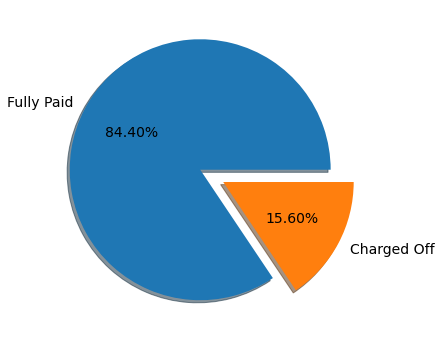

In [12]:
plt.figure(figsize=(8,6))
plt.pie(df.loan_status.value_counts(), labels=df.loan_status.unique(),
        explode=(0, 0.2), autopct='%1.2f%%', shadow=True, textprops={'fontsize': 14});

Let's convert target variable from categorical to numerical for the more comfortable analysis.

In [13]:
df['Target'] = df.loan_status.map({'Fully Paid' : 0, 'Charged Off': 1})
df.drop(['loan_status'], axis=1, inplace=True, errors='ignore')

In [14]:
del accepted

## 3.2 Dropping missing values

In [15]:
df_full = df.copy()

Let's visualize the distribution of missing values ratio by columns:

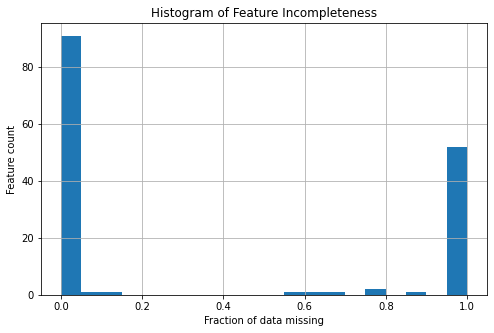

In [16]:
plt.figure(figsize=(8,5))
(df.isna().sum() / df.shape[0]).hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count');

In the plot we can observe large gap between features missing small percentage of data (<20%) and those missing significant proportion of data (>40%).  
Let's drop all columns with more than 20% missing values.

In [17]:
df.dropna(axis=1, thresh = 0.8*df.shape[0], inplace=True)

## 3.3 Useless features

Let's find constant features (null variance for numerical features and only one value for categorical features).

In [18]:
null_var_col =  list((df.std() == 0).index[(df.std() == 0)]) + list(df.describe(include=['object']).T.query('unique == 1').index)
df[null_var_col].head(3)

,out_prncp,out_prncp_inv,policy_code,pymnt_plan,application_type,hardship_flag,disbursement_method
1751198,0.0,0.0,1.0,n,Individual,N,Cash
1751199,0.0,0.0,1.0,n,Individual,N,Cash
1751200,0.0,0.0,1.0,n,Individual,N,Cash


Let's delete these features

In [19]:
df.drop(columns=null_var_col, inplace=True, errors='ignore')

Now let's delete personal or irrelevant columns.
* ID
* URL
* The month which the loan was funded 
* Zip code
* Employment title
* The loan title provided by the borrower
* State of residence

Also information that contains information **up until the present time** because this data can not be used for prediction. Such as:  
* total_pymnt - Payments received to date for total amount funded  
* total_pymnt_inv - Payments received to date for portion of total amount funded by investors  
* total_rec_prncp - Principal received to date  
* total_rec_int - Interest received to date 
* total_rec_late_fee - Late fees received to date
* debt_settlement_flag - The indication of settlement negotiatied with an insecured debtor  
* funded_amnt - The total amount committed to that loan at that point in time
* funded_amnt_inv - The total amount committed by investors for that loan at that point in time.  

Description of features is taken from [Data Dictionary](http://rstudio-pubs-static.s3.amazonaws.com/290261_676d9bb194ae4c9882f599e7c0a808f2.html).

In [20]:
useless_cols = ['id', 'url', 'issue_d', 'title', 'zip_code', 'debt_settlement_flag', 'emp_title',
                'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                'last_fico_range_high', 'last_fico_range_low', 'addr_state', 'funded_amnt', 'funded_amnt_inv']
df[useless_cols].sample(2)

,id,url,issue_d,title,zip_code,debt_settlement_flag,emp_title,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_fico_range_high,last_fico_range_low,addr_state,funded_amnt,funded_amnt_inv
1783953,7079415,https://lendingclub.com/browse/loanDetail.acti...,Oct-2013,Debt Consolidation,336xx,N,VP Human Resources,25106.338362,25046.56,21000.00,4106.34,0.0,714.0,710.0,FL,21000.0,20950.0
1774358,8628754,https://lendingclub.com/browse/loanDetail.acti...,Nov-2013,My Debt pay off,923xx,N,VP Special Assets C & I Loans,15922.140000,15922.14,5010.69,7427.45,0.0,629.0,625.0,CA,23850.0,23850.0


In [21]:
df.drop(columns=useless_cols, inplace=True, errors='ignore')

Let's set variables with categorical and numerical columns

In [22]:
cat_cols = df.dtypes[df.dtypes == 'object'].index
num_cols = df.dtypes[~(df.dtypes == 'object')].index

## 3.4 Numerical Features

### 3.4.1 Multicollinearity

In order to detect and drop correlating features I am going firstly to calculate VIF of numerical features.

In [23]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif.sort_values(by=['VIF'], ascending=False))

vif = calc_vif(df[num_cols].fillna(df[num_cols].mean()).iloc[:,:-1])

Now I'b going to investigate correlation matrix of features with the largest VIF and pick clusters of correation features for further deletion.

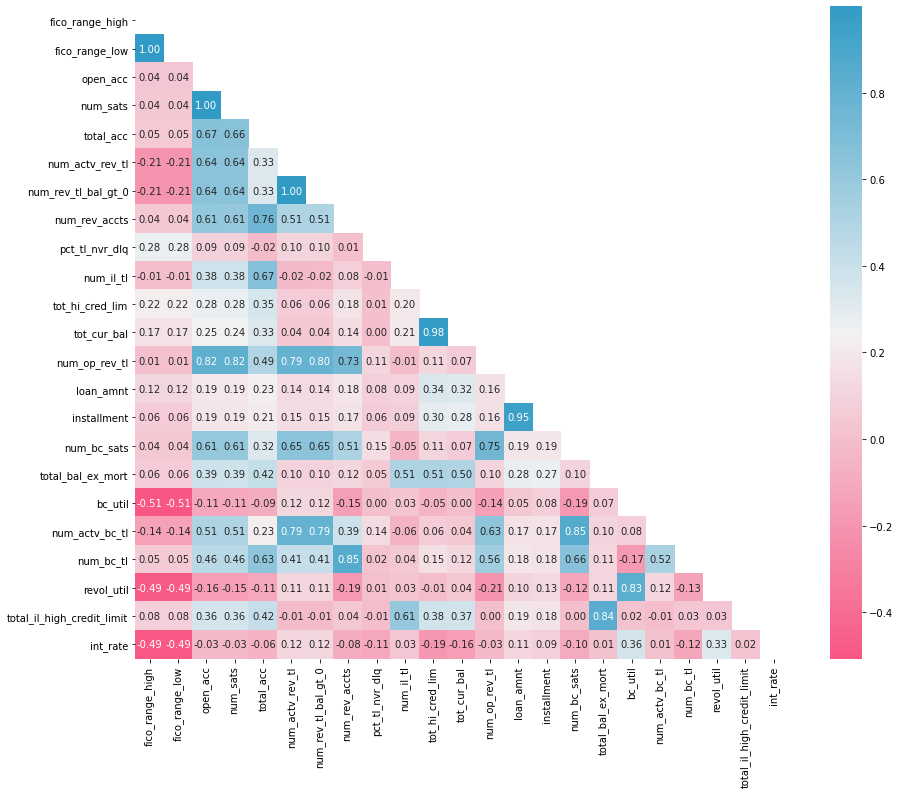

In [24]:
multicol = vif.head(23)['variables']
plt.figure(figsize=(15,12))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)# plot heatmap
mask = np.zeros_like(df[multicol].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df[multicol].corr(), cmap=cmap, mask=mask, annot=True, fmt=".2f", square=True);

Let's look at description.  
*fico_range_low*: "The lower boundary range the borrower’s FICO at loan origination belongs to."  
*fico_range_high*: "The upper boundary range the borrower’s FICO at loan origination belongs to."

I will create new feature as a mean between these two variables

In [25]:
df['fico_range'] = 0.5*df['fico_range_high'] + 0.5*df['fico_range_low']

Further, I am going make scatterplots of cluster of dependent variables and delete some of them.

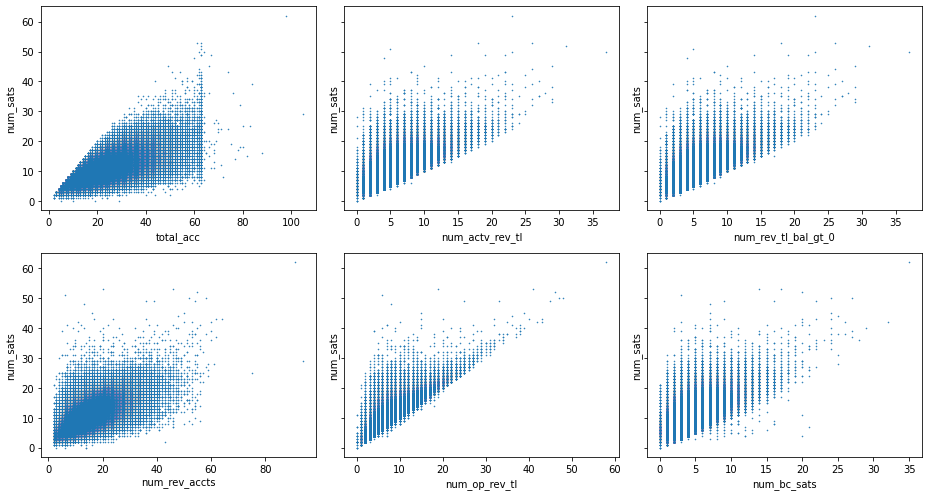

In [26]:
fig, axes = plt.subplots(2,3, figsize=(13,7), sharey=True);
features = ['total_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_rev_accts', 'num_op_rev_tl', 'num_bc_sats']
for i, axis in enumerate(axes.flat):
    feature = df[features[i]]
    axis.scatter(feature, df['num_sats'], s=0.3)
    axis.set_xlabel(features[i])
    axis.set_ylabel('num_sats')
plt.tight_layout()

Since all these features are correlated with *open_acc* (The number of open credit lines in the borrower's credit file) with coefficients from 0.61 to 1 and some of them are intercorrelated, I am going to drop them all.


In [27]:
df.drop(['total_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_rev_accts', 'num_op_rev_tl', 'num_bc_sats'], axis=1, inplace=True, errors='ignore')

Let's look at other pairs of correlated features.

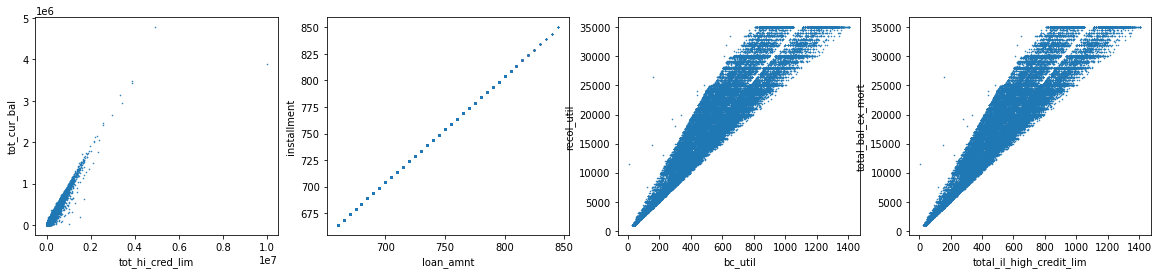

In [28]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,4,1)
ax.scatter(df.tot_hi_cred_lim, df.tot_cur_bal, s=0.3)
ax.set_xlabel('tot_hi_cred_lim')
ax.set_ylabel('tot_cur_bal')
ax = fig.add_subplot(1,4,2)
ax.scatter(df.fico_range_low, df.fico_range_high,  s=0.3)
ax.set_xlabel('loan_amnt')
ax.set_ylabel('installment')
ax = fig.add_subplot(1,4,3)
ax.scatter(df.installment, df.loan_amnt,  s=0.3)
ax.set_xlabel('bc_util')
ax.set_ylabel('recol_util')
ax = fig.add_subplot(1,4,4)
ax.scatter(df.installment, df.loan_amnt,  s=0.3)
ax.set_xlabel('total_il_high_credit_lim')
ax.set_ylabel('total_bal_ex_mort')
plt.show()

And let's drop one from each pair.

In [29]:
df.drop(['tot_hi_cred_lim',  'installment', 'revol_util', 'total_bal_ex_mort'], axis=1, inplace=True)

In [30]:
df.shape

(134804, 60)

### 3.4.2 Correlation of predictors with target feature

Now let's examine whether any feature is heavily correlated with target variable in order to find features that contain information emerged after the issue of loan and thus unfit for prediction.

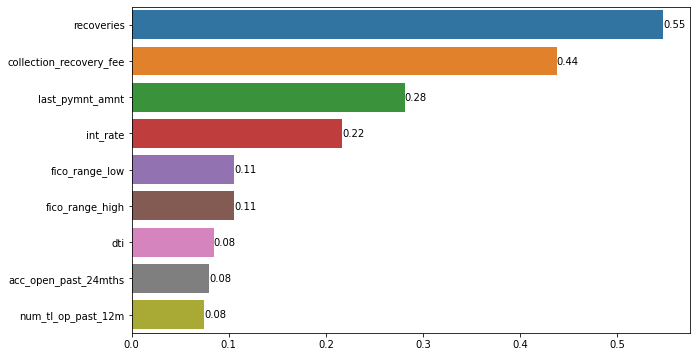

In [31]:
cor_tar = df.iloc[:, :-1].corrwith(df['Target']).abs().sort_values(ascending=False).head(10)[1:]
plt.figure(figsize=(10,6))
bar = sns.barplot(cor_tar, cor_tar.index, )
for p in bar.patches:
    width = p.get_width()    # get bar length
    bar.text(width,  # set the text at bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

Let's check statistical metrics and description of 4 most correlated features.

*Recoveries* - post charge off gross recovery

In [32]:
df.groupby(['Target'])['recoveries'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113780.0,0.000000,0.000000,0.0,0.0000,0.00,0.00,0.00
1,21024.0,1322.517665,1858.587445,0.0,7.4075,771.82,1889.73,39444.37


*collection_recovery_fee* - post charge off collection fee

In [33]:
df.groupby(['Target'])['collection_recovery_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113780.0,0.000000,0.000000,0.0,0.0,0.00000,0.000,0.000
1,21024.0,165.769811,312.906316,0.0,0.0,29.47555,198.549,6124.938


*last_pymnt_amnt* - last total payment amount received

In [34]:
df.groupby(['Target'])['last_pymnt_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113780.0,5125.116450,6235.246529,0.01,467.0400,2546.030,7811.86,35760.20
1,21024.0,492.075894,613.142315,0.00,287.0625,421.735,601.97,34833.35


*int_rate* - interest Rate on the loan

In [35]:
df.groupby(['Target'])['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113780.0,14.118374,4.349962,6.0,10.99,13.98,17.10,26.06
1,21024.0,16.768118,4.233957,6.0,13.68,16.29,19.52,26.06


Such features as *recoveries*,  *collection_recovery_fee*, *last_pymnt_amnt* describe data after the issue of loand and thus unfit for prediction.

In [36]:
df.drop(['recoveries',  'collection_recovery_fee', 'last_pymnt_amnt'], axis=1, inplace=True)

## 3.5 Categorical columns

Let's take a quick glance at categorical_features.

In [37]:
df[cat_cols].sample(5)

,term,grade,sub_grade,emp_length,home_ownership,verification_status,purpose,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d
1760947,60 months,D,D5,10+ years,RENT,Source Verified,debt_consolidation,Nov-2002,f,Feb-2014,Apr-2018
1809089,36 months,A,A1,10+ years,MORTGAGE,Verified,debt_consolidation,Feb-1986,w,Apr-2016,May-2016
1860094,36 months,D,D1,9 years,MORTGAGE,Not Verified,other,Jul-1995,w,Jun-2015,Mar-2019
1874488,36 months,B,B5,10+ years,MORTGAGE,Verified,credit_card,Mar-2003,f,Jan-2016,Feb-2017
1874084,36 months,C,C5,10+ years,MORTGAGE,Source Verified,small_business,Sep-1982,f,May-2015,Mar-2019


Such features as last_pymnt_d, last_credit_pull_d, earliest_cr_line contain dates that I am not going to use in my models. Let's drop them.

In [38]:
df.drop(['last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line'], axis=1, inplace=True, errors='ignore')

# 4. Exploratory Data Analysis

I will examine important features to determine differences in distribution by target variable and propose hypotheses.

In [39]:
df_before_eda = df.copy()

In [40]:
df.sample(5)

,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,initial_list_status,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_tl,num_il_tl,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bc_limit,total_il_high_credit_limit,Target,fico_range
1780503,26000.0,60 months,19.52,D,D4,10+ years,MORTGAGE,70000.0,Source Verified,debt_consolidation,17.47,0.0,710.0,714.0,0.0,13.0,0.0,24341.0,f,0.0,0.0,0.0,127255.0,32200.0,0.0,9789.0,1056.0,92.3,0.0,0.0,129.0,258.0,31.0,31.0,1.0,52.0,9.0,0.0,5.0,12.0,9.0,13.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,13700.0,24956.0,0,712.0
1766833,35000.0,60 months,21.00,E,E1,10+ years,MORTGAGE,110000.0,Verified,debt_consolidation,24.45,1.0,695.0,699.0,4.0,19.0,0.0,34790.0,f,0.0,0.0,0.0,74806.0,53200.0,0.0,4675.0,4600.0,0.0,0.0,0.0,235.0,289.0,32.0,27.0,3.0,46.0,3.0,0.0,0.0,7.0,18.0,19.0,0.0,0.0,0.0,0.0,95.0,0.0,0.0,0.0,4600.0,38463.0,1,697.0
1848228,14300.0,36 months,16.29,C,C4,6 years,RENT,55000.0,Source Verified,credit_card,30.73,0.0,665.0,669.0,1.0,10.0,0.0,7512.0,w,0.0,0.0,0.0,51254.0,8300.0,7.0,5125.0,467.0,93.1,0.0,0.0,106.0,139.0,6.0,6.0,0.0,21.0,6.0,0.0,5.0,13.0,7.0,10.0,0.0,0.0,0.0,2.0,100.0,80.0,0.0,0.0,6800.0,51052.0,0,667.0
1844218,18000.0,36 months,18.75,D,D3,10+ years,RENT,78000.0,Source Verified,debt_consolidation,22.66,0.0,680.0,684.0,1.0,16.0,1.0,20744.0,f,0.0,0.0,0.0,50661.0,29500.0,3.0,3166.0,2914.0,77.8,0.0,0.0,88.0,463.0,3.0,3.0,2.0,3.0,3.0,1.0,4.0,8.0,4.0,16.0,0.0,0.0,0.0,2.0,96.0,66.7,1.0,0.0,13100.0,41712.0,0,682.0
1842096,10000.0,60 months,8.90,A,A5,7 years,MORTGAGE,90000.0,Verified,debt_consolidation,15.85,0.0,730.0,734.0,0.0,13.0,0.0,15970.0,w,0.0,0.0,0.0,208529.0,42500.0,2.0,16041.0,16812.0,40.6,0.0,0.0,175.0,162.0,20.0,20.0,4.0,23.0,13.0,0.0,4.0,7.0,14.0,13.0,0.0,0.0,0.0,0.0,100.0,20.0,0.0,0.0,28300.0,13819.0,0,732.0


,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113780.0,14525.781113,8035.161158,1000.0,8400.0,12800.0,20000.0,35000.0
1,21024.0,15690.145786,8366.581832,1000.0,9600.0,15000.0,20950.0,35000.0


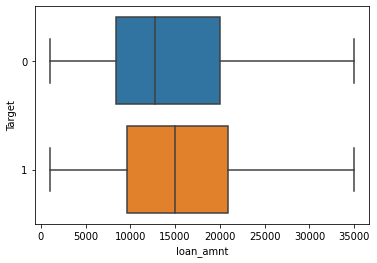

In [41]:
sns.boxplot(x=df.loan_amnt, y=df.Target.astype(str))
df.groupby(['Target'])['loan_amnt'].describe()

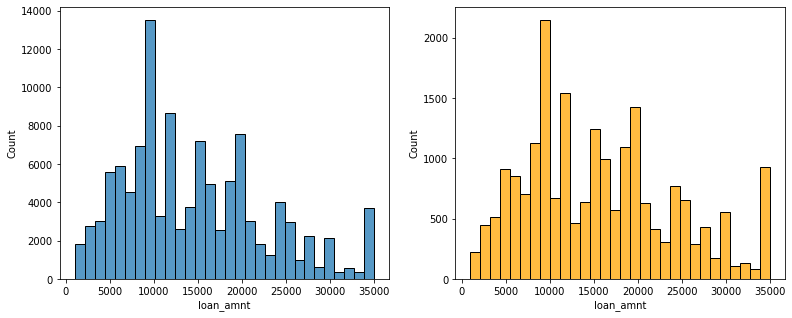

In [42]:
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.histplot(df.query('Target == 0')['loan_amnt'], bins=30, ax=ax[0])
sns.histplot(df.query('Target == 1')['loan_amnt'], bins=30, color='orange', ax=ax[1]);

As we can see, amount of the loan is higher for those that failed to pay it afterwards, but distribution of its feature is basically the same for both categories.  
It looks like important feature for model building.

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113780.0,74369.371546,49994.861058,6000.0,46800.0,65000.0,90000.0,6100000.0
1,21024.0,67044.086603,41370.708617,7200.0,43000.0,59000.0,80000.0,950000.0


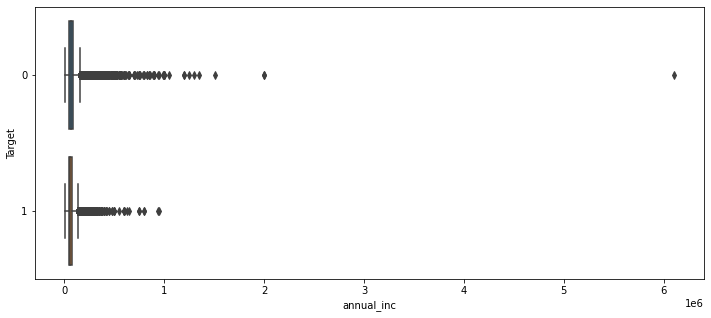

In [43]:
plt.figure(figsize=(12,5))
sns.boxplot(x=df.annual_inc, y=df.Target.astype(str))
df.groupby(['Target'])['annual_inc'].describe()

This feature has too many outliers. In order to fix this problem, let's use apply logarithm.

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113780.0,11.083481,0.502077,8.699515,10.753638,11.082143,11.407565,15.623799
1,21024.0,10.985379,0.490239,8.881836,10.668955,10.985293,11.289782,13.764217


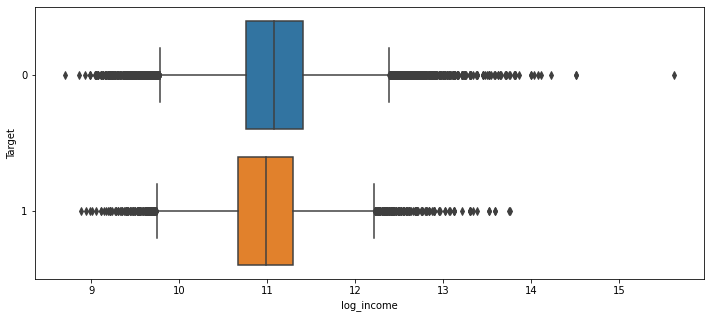

In [44]:
df['log_income'] = np.log(df.annual_inc)
plt.figure(figsize=(12,5))
sns.boxplot(x=df.log_income, y=df.Target.astype(str))
df.groupby(['Target'])['log_income'].describe()

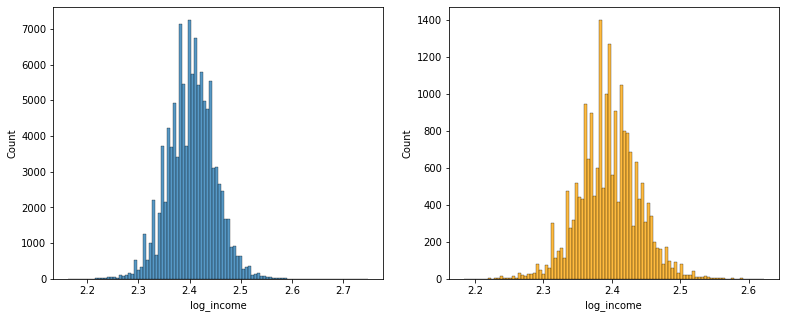

In [45]:
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.histplot(np.log(df.query('Target == 0').log_income), bins=100, ax=ax[0])
sns.histplot(np.log(df.query('Target == 1').log_income), bins=100, color='orange', ax=ax[1])

Those who paid loan have higher annual income, so it must be very important feature. Also, distribution of variable now is normal and contains not so extreme outliers.  
Let's drop original variable.

In [46]:
df.drop(columns=['annual_inc'], inplace=True)

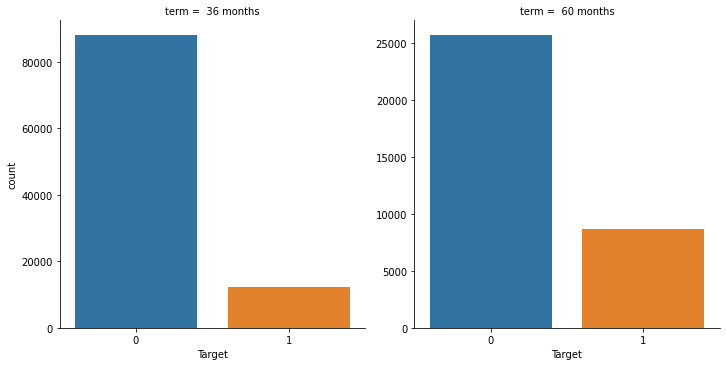

In [47]:
sns.catplot(data=df, x='Target', kind='count', col='term', height=5, sharey=False);

Loans with higher term are significantly more likely to be charged off and thus should constitute important feature.

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113780.0,14.118374,4.349962,6.0,10.99,13.98,17.10,26.06
1,21024.0,16.768118,4.233957,6.0,13.68,16.29,19.52,26.06


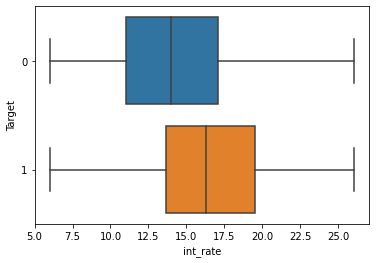

In [48]:
sns.boxplot(x=df.int_rate, y=df.Target.astype(str))
df.groupby(['Target'])['int_rate'].describe()

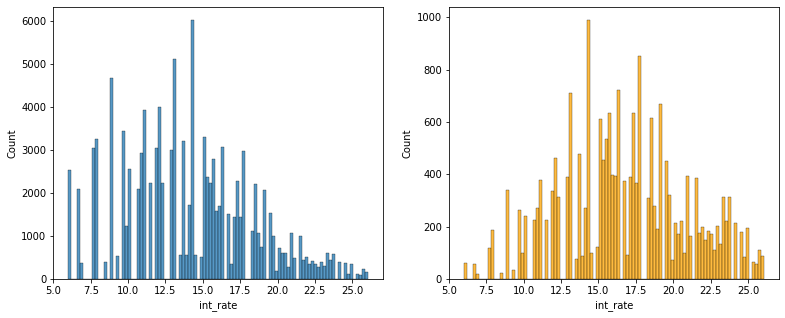

In [49]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

sns.histplot(df.query('Target == 0').int_rate, bins=100, ax=ax[0])
sns.histplot(df.query('Target == 1').int_rate, bins=100, color='orange', ax=ax[1])


Mean and median interest rate for charged off loans are also in general higher, but minimum and maximum values don't differ. Variance is also does not differ sinificantly. It is matter of dispute whether it will be good predictor.

Now let's check distribution of *grade* and *sub_grade* features.

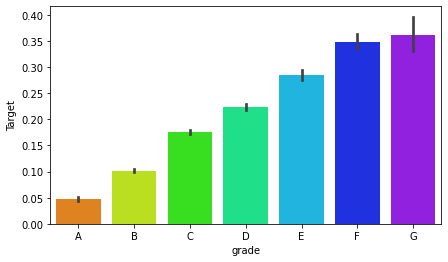

In [50]:
plt.figure(figsize=(7,4))
sns.barplot(x='grade', y='Target', data=df, 
                  order=sorted(list(df.grade.unique())), palette='gist_rainbow')

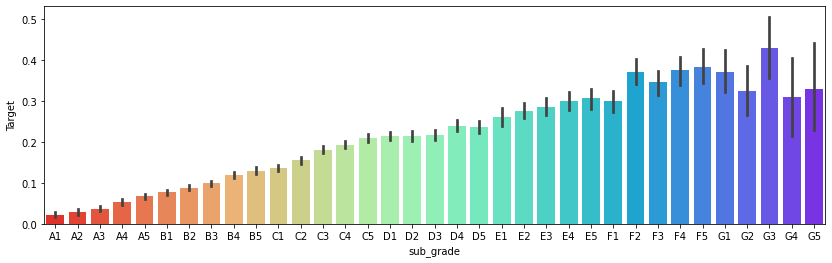

In [51]:
plt.figure(figsize=(14,4))
sns.barplot(x='sub_grade', y='Target', data=df, 
                  order=sorted(list(df.sub_grade.unique())), palette='rainbow_r')

Looks like sub_grade provide us with more gradual (but not linear in all places) prediction of target variable.  
So, i will transform sub_grade into new numerical feature and drop grade and sub_grade.

In [52]:
subgrade_to_int = dict(zip(
    sorted(list(df.sub_grade.unique())),
    range(1,len(df.sub_grade.unique()))
))
df['Subgrade_num'] = df['sub_grade'].map(subgrade_to_int)
df.drop(columns=['grade', 'sub_grade'], inplace=True, errors='ignore')

,count,mean,std,min,25%,50%,75%,max
Target,,,,,,,,
0,113733.0,11.455365,6.151678,1.0,7.0,11.0,15.0,34.0
1,21001.0,15.273749,6.553767,1.0,10.0,14.0,19.0,34.0


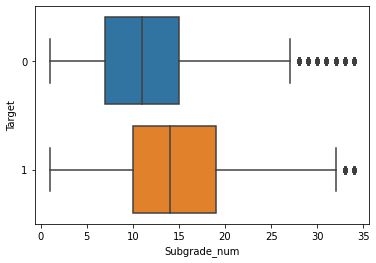

In [53]:
sns.boxplot(x=df.Subgrade_num, y=df.Target.astype(str))
df.groupby(['Target'])['Subgrade_num'].describe()

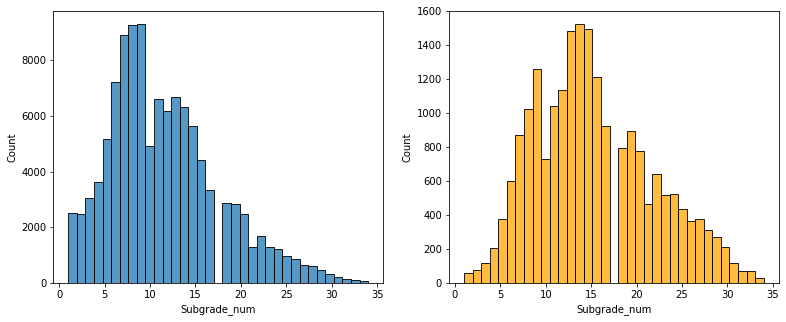

In [54]:
fig, ax = plt.subplots(1,2, figsize=(13,5))

sns.histplot(df.query('Target == 0').Subgrade_num, bins=35, ax=ax[0])
sns.histplot(df.query('Target == 1').Subgrade_num, bins=35, color='orange', ax=ax[1])

Borrowers that failed to pay loan in general were extimated worse. It will probably be one of most important features for prediciton.

,MORTGAGE,RENT,OWN
home_ownership,72061,51495,11248


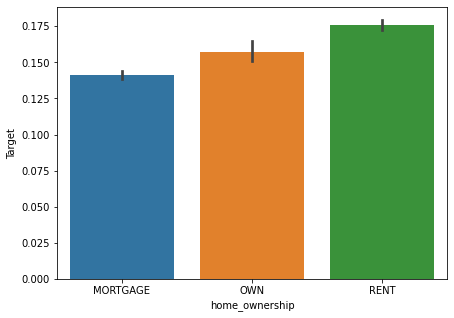

In [55]:
plt.figure(figsize=(7,5))
sns.barplot(x='home_ownership', y='Target', data=df)
df['home_ownership'].value_counts().to_frame().T

Loans of clients with rented houses tend to be charged off more often, but difference is quite small, so this feature is probably not very significant.

In [56]:
df['purpose'].value_counts().to_frame().T

,debt_consolidation,credit_card,home_improvement,other,major_purchase,small_business,car,medical,house,moving,wedding,vacation,renewable_energy
purpose,80634,32804,7403,5842,2298,1359,1050,889,675,639,595,565,51


,debt_consolidation,credit_card,home_improvement,other,major_purchase,small_business,car,medical,house,moving,wedding,vacation,renewable_energy
purpose,80634,32804,7403,5842,2298,1359,1050,889,675,639,595,565,51


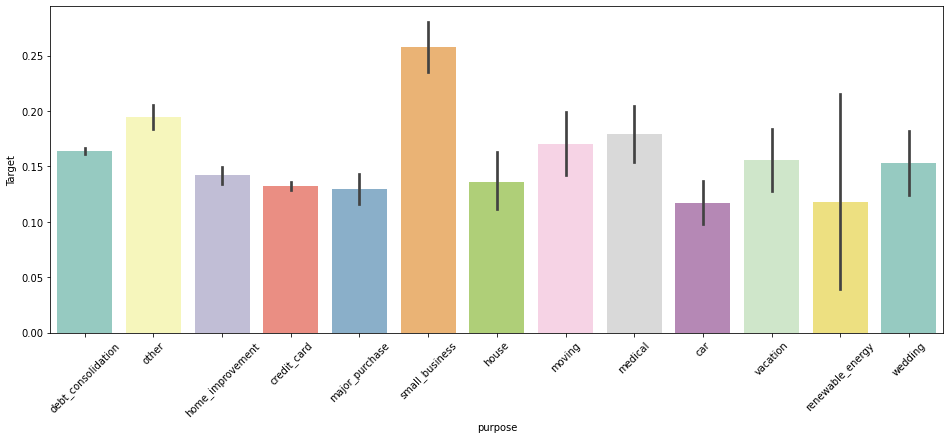

In [57]:
plt.figure(figsize=(16,6))
sns.barplot(x='purpose', y='Target', data=df, palette='Set3')
plt.xticks(rotation=45)
df['purpose'].value_counts().to_frame().T

Loans with the purpose of small business tend to be charged off more often and loans for renewable energy tend to be charged off less often. though this category has smallest amount of objects.  
But in general categories do not have significant differences.

,0.0,1.0,2.0,3.0,4.0,6.0,5.0,7.0,8.0
pub_rec_bankruptcies,120491,14010,239,37,18,4,3,1,1


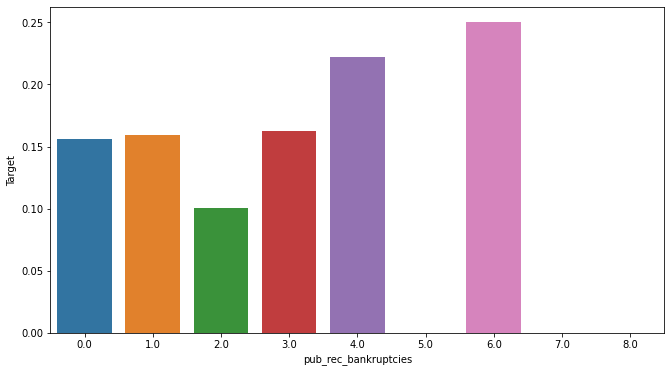

In [58]:

plt.figure(figsize=(11,6))
sns.barplot(x='pub_rec_bankruptcies', y='Target', ci=None, data=df, palette='tab10')
df['pub_rec_bankruptcies'].value_counts().to_frame().T

,Verified,Not Verified,Source Verified
verification_status,66138,38959,29707


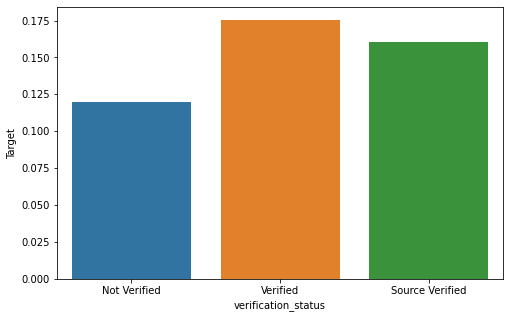

In [59]:
plt.figure(figsize=(8,5))
sns.barplot(x='verification_status', y='Target', ci=None, data=df, palette='tab10')
df['verification_status'].value_counts().to_frame().T

This variable indicates if income was verified by LC [Lending Club], not verified, or if the income source was verified.  
We can see notable difference between groups.

# 5. Preprocessing

Now let's prepare data for model building Catboosе (without One-Hot-Encoding) and for other models (with One-Hot-Enсoding).

In [60]:
def preprocessing_boost(data):

  cat_features = list(data.dtypes[data.dtypes == 'object'].index)
  num_features = list(data.dtypes[~(data.dtypes == 'object')].index)

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='mean'))]) 

  categor_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant'))])

  preprocessor = ColumnTransformer(transformers=[
      ('numeric_transformer', numeric_transformer, num_features),
      ('categor_transformer', categor_transformer, cat_features)])
  
  data_bst = pd.DataFrame(preprocessor.fit_transform(data), columns=num_features+cat_features)
  
  return data_bst, cat_features

In [61]:
def preprocessing_ohe(data):

  cat_features = list(data.dtypes[data.dtypes == 'object'].index)
  num_features = list(data.dtypes[~(data.dtypes == 'object')].index)

  
  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='mean')),
      ('scaler', StandardScaler())]) 

  
  data[cat_features].fillna('missing_value', inplace=True)
  ohe = ce.OneHotEncoder(return_df=True, use_cat_names=True)

  num_data = pd.DataFrame(numeric_transformer.fit_transform(data[num_features]), columns=num_features, index=data.index)
  cat_data = ohe.fit_transform(data[cat_features])
  
  data_ohe = pd.concat([num_data, cat_data], axis=1, ignore_index=True)
  data_ohe.columns = list(num_data.columns) + list(cat_data.columns)
  
  return data_ohe

In [62]:
X_ohe = preprocessing_ohe(df.drop(columns='Target'))
X_cbt, cat_features = preprocessing_boost(df.drop(columns='Target'))
y = np.array(df['Target'])

# 6. Model training

## 6.1. Comparison of models

Now we are going to train different models with default parameters in order to determine the most effective one and conduct parameter tuning for it further.

In [63]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV,  SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

I am going to carry out cross validation with the set ratio of classes and will use StratifiedKFold method with 5 splits and shuffle.

In [64]:
SKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

Let's determine models and set balanced class weights where it is possible. 

In [65]:
classifiers = [
               ('Logistic Regression', LogisticRegression(class_weight='balanced')),
               ('SGDClassifier', SGDClassifier(class_weight='balanced')),
               ('LinearSVC', CalibratedClassifierCV(base_estimator = LinearSVC(class_weight='balanced'))),
               ('Random Forest', RandomForestClassifier(class_weight='balanced')),
               ('Ada Boost', AdaBoostClassifier( )),
               ('LightGBM', LGBMClassifier(class_weight='balanced'))
]

In [66]:
%%time
results = []
for clf in classifiers:
  model = clf[1]
  cvs = cross_val_score(model, X_ohe, y, scoring='roc_auc', cv=SKFold, n_jobs=-1, verbose=1)
  results.append([clf[0], cvs.mean(), cvs.std()])
  print(f'ROC_AUC-score of model {clf[0]} is mean {cvs.mean()} with {cvs.std()} standard deviation.')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC_AUC-score of model Logistic Regression is mean 0.6978659424129314 with 0.002761163053024759 standard deviation.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC_AUC-score of model SGDClassifier is mean 0.6841031305512897 with 0.004740594403923274 standard deviation.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC_AUC-score of model LinearSVC is mean 0.6970189818308875 with 0.0027041026464911357 standard deviation.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC_AUC-score of model Random Forest is mean 0.6795480045702594 with 0.004270085894846004 standard deviation.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC_AUC-score of model Ada Boost is mean 0.6930507396098573 with 0.0033219423366280774 standard deviation.
ROC_AUC-score of model LightGBM is mean 0.6968589310228134 with 0.0030098670417056696 standard deviation.
CPU times: user 7.53 s, sys: 1.56 s, total: 9.08 s
Wall time: 22min 32s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


Since Catboost requires the exact ratio of classes for *class_weight* parameter, I am going to use special method for computing balanced weights based on ratio of values in variable.

In [67]:
classes = class_weight.compute_sample_weight('balanced', np.unique(y), y)
classes

array([0.59238882, 3.2059551 ])

In [71]:
cb = CatBoostClassifier(eval_metric = 'AUC', cat_features = cat_features,  verbose=False, class_weights=classes)
cvs = cross_val_score(cb, X_cbt, y, scoring='roc_auc', cv=SKFold)
results.append(['Catboost', cvs.mean(), cvs.std()])
print(f'ROC_AUC-score of Catboost is mean {cvs.mean()} with {cvs.std()} standard deviation.')

ROC_AUC-score of Catboost is mean 0.6939660410945369 with 0.0031008633247636293 standard deviation.


Let's look at perfromance of all models.

In [72]:
pd.DataFrame(results, columns=['model', 'mean', 'std']).sort_values(by='mean', ascending=False)

,model,mean,std
0,Logistic Regression,0.697866,0.002761
2,LinearSVC,0.697019,0.002704
5,LightGBM,0.696859,0.003010
7,Catboost,0.693966,0.003101
4,Ada Boost,0.693051,0.003322
6,Catboost,0.690416,0.002838
1,SGDClassifier,0.684103,0.004741
3,Random Forest,0.679548,0.004270


Turns out, they don't differ that much. The best model with dummy variables is Logistic Regression.  
Catboost is at 4th place.  
Further I am going to tune parameters for these two models in order to determine whether dummy categorical features as dummy variables have significant importance or they are better predictors as unified variables. 

## 6.2. Model Tuning

Let's find the most effective parameter of C (regularization strength) by applying LogisticRegressionCV.



In [73]:
logreg = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1], cv=SKFold, scoring='roc_auc', n_jobs=-1, verbose=1,)
logreg.fit(X_ohe, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.9s finished


LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1], class_weight=None,
                     cv=StratifiedKFold(n_splits=5, random_state=13, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=1)

In [74]:
print(f'The best value of regularization strength is {logreg.Cs[np.argmax(logreg.scores_[1].mean(axis=0))]} ' 
f'with the mean roc_auc-score of {max(logreg.scores_[1].mean(axis=0)).round(5)}')

The best value of regularization strength is 0.1 with the mean roc_auc-score of 0.69794


Now let's tune parameters for Catboost.

In [ ]:
params = {'learning_rate' : [0.05, 0.1],
         'l2_leaf_reg': [5,7],
         'depth': [3,8],
         'loss_function': ['Logloss'],
         'iterations': [500]}
cb = CatBoostClassifier(eval_metric = 'AUC', cat_features = cat_features, class_weights=classes)
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = SKFold,  
                        n_jobs=-1, verbose=0)
cb_model.fit(X_cbt, y)

In [80]:
print('The best parameters of Catboost Classifier after Model Tuning are \n', cb_model.best_params_, sep='')
print()
print('Best score for Catboost Classifier is',cb_model.best_score_)
cb_best = cb_model.best_estimator_

The best parameters of Catboost Classifier after Model Tuning are 
{'depth': 3, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'loss_function': 'Logloss'}

Best score for Catboost Classifier is 0.7017200644797781


As we can see, ROC_AUC-score for Catboost is higher. 

In [81]:
X_train_cbt, X_test_cbt, y_train_cbt, y_test_cbt = train_test_split(X_cbt, y, test_size=0.25, stratify=y, random_state=28)

In [85]:
cb_best.fit(X_train_cbt, y_train_cbt, eval_set=(X_test_cbt, y_test_cbt), early_stopping_rounds=20, verbose=0)
pred = cb_best.predict_proba(X_test_cbt)
print('roc_auc_score on testing set is', roc_auc_score(y_test_cbt, pred[:,1]))

roc_auc_score on testing set is 0.701999379025399


## 6.3 Evaluation of model

Let's visualize ROC-curve and PR-curve.

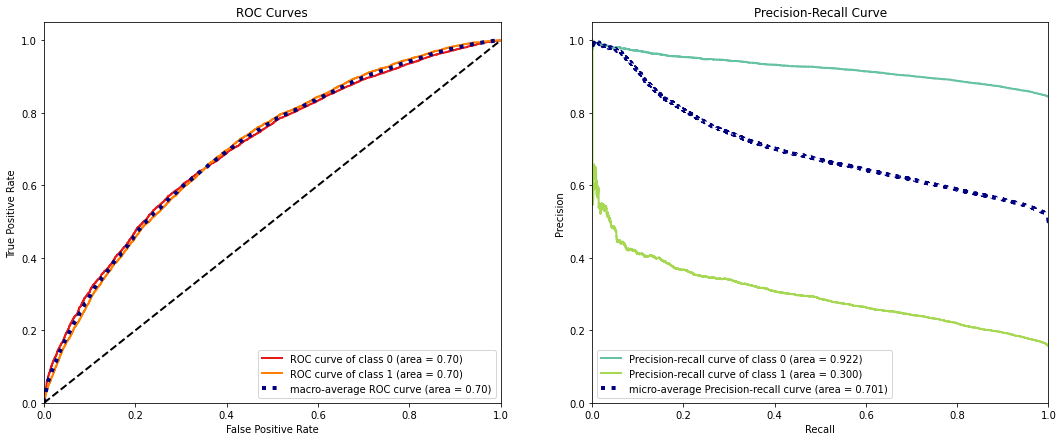

In [91]:
fig, ax = plt.subplots(1,2, figsize=(18,7))
plot_roc_curve(y_test_cbt, pred, title_fontsize='large', curves=('each_class', 'macro'),  text_fontsize='medium', cmap='Set1', ax=ax[0])
plot_precision_recall_curve(y_test_cbt, pred, title_fontsize='large',  text_fontsize='medium', cmap='Set2', ax=ax[1]);

While the overall predictive power of model is quite satisfactory, ability to predict Charged off loans is quite weak.  
In conclusion, by changing threshold we will have to find proper balance between high recall and large amount of False Positive or high precision and large amount of false negatives.

## 6.4 Feature Importance

Let's assess contribution of features in each model.

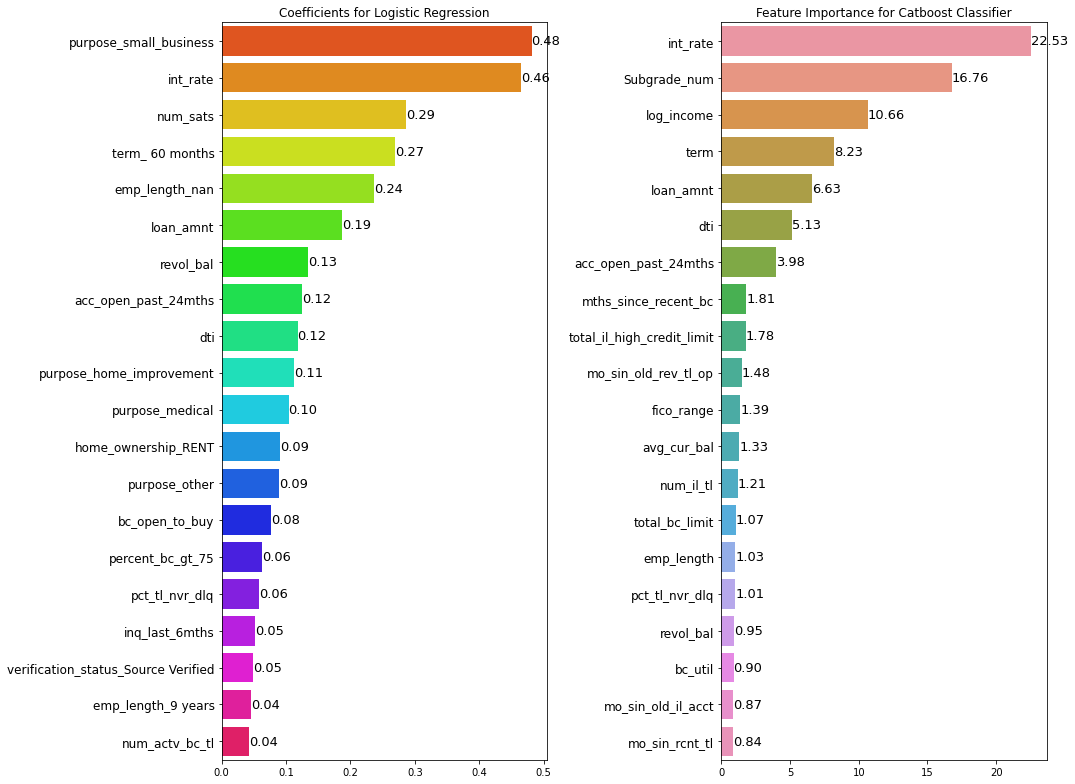

In [162]:
fig, axes = plt.subplots(1,2, figsize=(15,11))
feat_imp_lr = pd.Series(logreg.coef_[0], index=list(X_ohe)).sort_values(ascending=False).head(20)
feat_imp_cb = pd.Series(cb_best.feature_importances_, index=list(X_cbt)).sort_values(ascending=False).head(20)
imp = [(feat_imp_lr, 'Coefficients for Logistic Regression', 'hsv'), 
       (feat_imp_cb, 'Feature Importance for Catboost Classifier', None)]
for i, axis in enumerate(axes.flat):
  imp_series, title, cmap = imp[i]
  bar = sns.barplot(imp_series, imp_series.index, palette=cmap, ax=axis)
  axis.tick_params(axis='y', labelsize=12) 
  axis.set_title(title)
  for p in bar.patches:
      width = p.get_width()    # get bar length
      bar.text(width,  # set the text at bar
              p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
              '{:1.2f}'.format(width), # set variable to display, 2 decimals
              ha = 'left',   # horizontal alignment
              va = 'center', # vertical alignment
              fontsize=13)  
plt.tight_layout()

Such features as *int_rate*, *loan_amnt*, *dti* turned out to bear high importance for both models. However, we can detect considerable differences.  
**Catboost** attaches importance to only numerical features - we do not see categorical ones in top 20.  
Meanwhile **Logistic Regression** outlines specific values of categorical features. For instance, *purpose_small_business*, *term_60_month* and *emp_lenth_nan* are in top features for** Logistic Regression**. These categories were detected to be more associated with loan default in EDA.  

It is important to note that some numerical features have high importance in one model and do not even have a place in the top for the another model.  
For **Logistic Regression** these are *num_sats*, and for Catboost - *Subgrade_num* and *log_income*.

# 7. Conclusion

Various machine learning methods were applied to predict the probability of loan default on the base of prior information known about a borrower. After training and evaluating different models, I chose CatBoost for its unique approach to deal with categorical features and Logistic Regression that showed the highest performance among models that used data after One-Hot-Encoder transformation.
We tuned both models and got ROC-AUC-scores of 0.697 for Logistic Regression and 0.701 for Catboost.
After that, we assessed the model performance of Catboost by ROC-curve and PR-curve and outlined relatively weak capability to predict charged off loans due to the fact of high imbalance in target variable.
We also found that two models prefer different features as most important for prediction.
